# 1. Camera Calibration

This script intends to calibrate a camera using an object.\
For this implementation we will use the DLT transform for the estimation of the camera parameters.



When dealing with an uncalibrated camera, 11 parameters are unknown, meaning we need at least **6 points** and assume the model of the camera is **affine**.
>**Problem specification:**
- Estimate the 11 elements of P given:
    - 3D coordinates $X_{i}$ of I $\geq$ 6 object points


<img src="/home/alegria/calibration/images/camera_orientation.png" width=400 height=400 />\


## Import the libraries

In [57]:
#%matplotlib qt
#%matplotlib notebook
import cv2
from matplotlib import pyplot as plt
import numpy as np
import scipy as sp
import seaborn as sns

from utils import *

## Generate world and image points

In [58]:
I_pts  = [[140,285],[908,338],[1655,391],[2450,431],[3223,465],[4070,535],[4945,552],[200,1045],[941,1112],[1682,1159],
           [2456,1232],[3243,1265],[4064,1326],[4878,1392],[661,2100],[1435,2166],[2222,2233],[3043,2306],[3877,2380],
          [4744,2460],[334,2400],[1148,2460],[1995,2547],[2849,2627],[3737,2713],[4658,2794],[834,2807],[1722,2907],[2629,2987]
          ,[3570,3080],[4551,3167],[474,3214],[1408,3314],[2389,3401],[3377,3488],[4437,3614]]
I_pts = np.asarray(I_pts)

### Definging World Points
X = [216,180,144,108,72,36,0,216,180,144,108,72,36,0,180,144,108,72,36,0,180,144,108,72,36,0,144,108,72,36,0,144,108,72,36,0]
Y = [72,72,72,72,72,72,72,36,36,36,36,36,36,36,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
Z = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,36,36,36,36,36,36,72,72,72,72,72,72,108,108,108,108,108,144,144,144,144,144]

world_pts_list = []
image_pts_list = []

n = (I_pts.shape[0])

for i in range(n):
    world_pts_list.append([X[i],Y[i],Z[i],1])
    image_pts_list.append([I_pts[i,0],I_pts[i,1],1])

world_pts = np.array(world_pts_list) 
image_pts = np.array(image_pts_list)


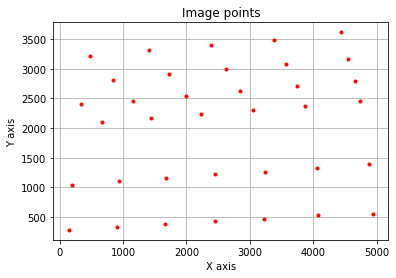

In [59]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(I_pts[:,0],I_pts[:,1], color = 'r',ls = "None", marker = ".")
ax.set_title("Image points")
ax.set_xlabel("X axis")
ax.set_ylabel("Y axis")
ax.grid()
plt.show()

## Direct Linear Transform(DLT)

In [60]:
# get the shape of the matrix
worldm, worldn = world_pts.shape
imagem, imagen = image_pts.shape


In [61]:
#3D DLT
A = []

for i in range(worldm):
    A = np.append(A,[world_pts[i,0],world_pts[i,1],world_pts[i,2],world_pts[i,3],0,0,0,0,-image_pts[i,0]*world_pts[i,0],-image_pts[i,0]*world_pts[i,1],-image_pts[i,0]*world_pts[i,2],-image_pts[i,0]])
    A = np.append(A,[0,0,0,0,world_pts[i,0],world_pts[i,1],world_pts[i,2],world_pts[i,3],-image_pts[i,1]*world_pts[i,0],-image_pts[i,1]*world_pts[i,1],-image_pts[i,1]*world_pts[i,2],-image_pts[i,1]])

# pass the list A as an array
A = np.asarray(A).reshape(n*2,12)
#print(A)
print(A.shape)

(72, 12)


## SVD(Singular Value Decomposition)
Solving a system of linear equations of the form Ax = 0 is equivalent to finding the null space of A. Thus, we can apply the SVD to solve Mp = 0 

### Q.M = 0

**Minimal solution**
- $Q_{(2n×12)}$ should have rank 11 to have a unique (up to a scale) non-zero solution 𝑀
- Because each 3D-to-2D point correspondence provides 2 independent equations, then 5+1/2 point correspondences are needed (in practice 6 point correspondences!)

**Over-determined solution**
- For 𝑛 ≥ 6 points, a solution is the Least Square solution, which minimizes the sum of squared residuals, | 𝑄𝑀 |2, subject to the constraint | 𝑀 |2 = 1.It can be solved through Singular Value Decomposition (SVD). The solution is the eigenvector corresponding to the smallest eigenvalue of the matrix $Q^TQ$(because it is the unit vector 𝑥 that minimizes $\|{Qx}\| = x^TQ^TQx$


In [62]:
# SVD 
U, S, Vh = np.linalg.svd(A)

L = Vh[-1,:] / Vh[-1,-1]
#Camera projection matrix:
PEst = L.reshape(3,3+1)
print("Camera Matrix:\n",PEst)

Camera Matrix:
 [[-2.11225340e+01 -1.52511970e+00 -9.72155998e+00  4.82458631e+03]
 [-1.09832879e+00 -2.24096507e+01  4.43993421e+00  2.15758505e+03]
 [ 3.60153742e-04 -6.15323260e-04 -1.57382436e-03  1.00000000e+00]]


### Predicted/Expected value

In [63]:
xEst = np.zeros((worldm,3))
for j in range(worldm):
    xEst[j,:]  = np.dot(PEst,world_pts[j])
    xEst[j,:] /= xEst[j,2]


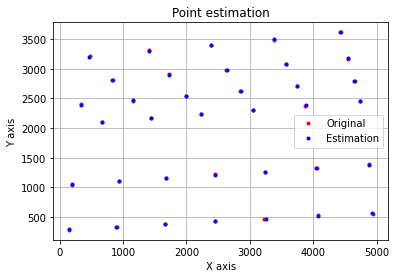

In [64]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(I_pts[:,0],I_pts[:,1], color = 'r',ls = "None", marker = ".", label = 'Original')
ax.set_title("Point estimation")
ax.set_xlabel("X axis")
ax.set_ylabel("Y axis")
ax.grid()
ax.plot(xEst[:,0],xEst[:,1], color = 'b',ls = "None", marker = ".", label = 'Estimation')
ax.legend()
plt.show()

## Geometric Error

$$E = \sum{d(x_i, MX_i)}$$
>d is the distance metric( euclidean distance)

In [65]:
err = np.sqrt(np.mean(np.sum(np.square(I_pts-xEst[:,:2]), 1)))
print("Geometric error:",err)


#cv2.SOLVEPNP_ITERATIVE()

Geometric error: 12.60866988230573


## Normalization
In order to improve the estimation, it is essential for DLT to normalize the data sample, as follows:
1. The points are tranlated so that their centroid is at the origin
2. The points are scaled so that the average distance from the origin is equal to $\sqrt{2}$
3. This transformation is applied to each of the two images independently

> Data normalization is an essential step in DLT. It must not be considered optional. - *Harley*

**Algorithm:**
- Normalization of X
- Normalization of x 
- DLT
- Denormalization

In [66]:

def normalization(data, dim):
    '''
    Normalization of coordinates (centroid to the origin and mean distance of sqrt(2 or 3).
    Inputs:
    data: the data to be normalized (directions at different columns and points at rows)
    Outputs:
    T : the transformation matrix (translation plus scaling)
    '''

    N = data.shape[0]
    
    if dim == 2:                                                     # 2D points
        x, y = data[:, 0], data[:, 1]                               # x and y coordinates
        x_mean, y_mean = x.mean(), y.mean()                         # mean 
        x_par = (x-x_mean)**2                                       # x part
        y_par = (y-y_mean)**2                                       # y part

        d = (1/N)* np.sum(np.sqrt(x_par + y_par))                   # d
        s_xy = np.sqrt(2)/d                                         # sqrt(2)/d

        T = np.zeros((3,3))                                         # normalization matrix for 2D points
        T[0,0] = s_xy
        T[0,2] = -x_mean*s_xy
        T[1,1] = s_xy
        T[1,2] = -y_mean*s_xy
        T[-1,-1] = 1

    elif(dim== 3):                                                  # 3D points
        X, Y, Z = data[:, 0], data[:, 1], data[:,2]                 # x and y coordinates
        X_mean, Y_mean,Z_mean = X.mean(), Y.mean(),Z.mean()         # mean 
        X_par = (X-X_mean)**2                                       # x part
        Y_par = (Y-Y_mean)**2                                       # y part
        Z_par = (Z-Z_mean)**2                                       # z part

        D = (1/N)* np.sum(np.sqrt(X_par + Y_par + Z_par))           # d
        s_xyz = np.sqrt(3)/D                                        # sqrt(2)/d

        T = np.zeros((4,4))                                         # normalization matrix for 3D points
        T[0,0] = s_xyz
        T[0,3] = -X_mean*s_xyz
        T[1,1] = s_xyz
        T[1,3] = -Y_mean*s_xyz
        T[2,2] = s_xyz
        T[2,3] = -Z_mean*s_xyz
        T[-1,-1] = 1
    else:
        raise ValueError('Dataset must be a collection of 2D or points')

    return T


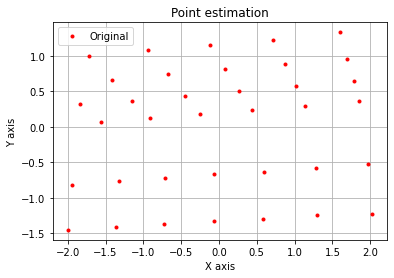

In [67]:
Txy = normalization(image_pts,2)
#print("Normalization matrix for 2D:\n",T_matrix)
Txyz = normalization(world_pts,3)
#print("Normalization matrix for 3D :\n",U_matrix)

#normalized imagecoordinates
xyn = np.dot(image_pts,Txy.T)
#normalized worldcoordinates
xyzn = np.dot(world_pts,Txyz.T)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(xyn[:,0],xyn[:,1], color = 'r',ls = "None", marker = ".", label = 'Original')
ax.set_title("Point estimation")
ax.set_xlabel("X axis")
ax.set_ylabel("Y axis")
ax.grid()
ax.legend()
plt.show()

For each image A generates a (2,12)

In [68]:
#3D DLT
A = []
sz = len(xyzn)

for i in range(sz):
    x, y, z = xyzn[i, 0], xyzn[i, 1], xyzn[i, 2]
    u, v = xyn[i, 0], xyn[i, 1]
    A.append( [x, y, z, 1, 0, 0, 0, 0, -u * x, -u * y, -u * z, -u] )
    A.append( [0, 0, 0, 0, x, y, z, 1, -v * x, -v * y, -v * z, -v] )

# pass the list A as an array
A = np.asarray(A).reshape(sz*2,12)
#print(A)
print(A.shape)



(72, 12)


In [69]:
# SVD 
U, S, Vh = np.linalg.svd(A)
L = Vh[-1,:] / Vh[-1,-1]
# Camera projection matrix
H_norm = L.reshape(3, 3 + 1)
print(H_norm)

[[-0.95061407  0.00135785 -0.24783624 -0.02930182]
 [-0.07876161 -0.91348273  0.32867535 -0.06296793]
 [ 0.01859844 -0.03148227 -0.08094851  1.        ]]


## Denormalization

In [70]:
# Denormalize the coordinates
H = np.dot( np.dot( np.linalg.pinv(Txy), H_norm ), Txyz )
H = H / H[-1, -2]
print(H)
print(H.shape)

[[ 1.34382637e+04  9.62521261e+02  6.18120371e+03 -3.06916527e+06]
 [ 6.97562239e+02  1.42564566e+04 -2.82772741e+03 -1.37249310e+06]
 [-2.29756469e-01  3.88917258e-01  1.00000000e+00 -6.36095705e+02]]
(3, 4)


### Predicted/Expected value

In [71]:

pts_norm = np.zeros((worldm,3))
for j in range(worldm):
    pts_norm[j,:]  = np.dot(H,world_pts[j])
    pts_norm[j,:] /= pts_norm[j,2]


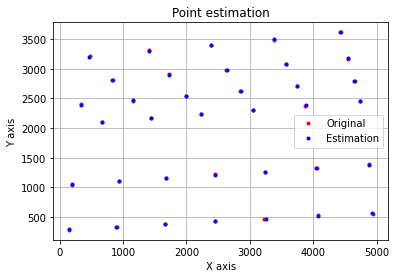

In [72]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(I_pts[:,0],I_pts[:,1], color = 'r',ls = "None", marker = ".", label = 'Original')
ax.set_title("Point estimation")
ax.set_xlabel("X axis")
ax.set_ylabel("Y axis")
ax.grid()
ax.plot(pts_norm[:,0],pts_norm[:,1], color = 'b',ls = "None", marker = ".", label = 'Estimation')
ax.legend()
plt.show()

## Geometric Error 
Geometric error essentially gives an estimate of how far the predictions are from the ground truth. It does so by measuring the distance between the predicted projection of a point and its ground truth projection. When we minimize the geometric error, we’re essentially minimizing the distance between the predictions and the ground truth.
$$E = \sum{d(x_i,x'_i)}$$

In [73]:
print(xEst.shape)
# Mean distance:
err = np.sqrt(np.mean(np.sum(np.square(I_pts-pts_norm[:,:2]), 1)))
print("Geometric Error after normalization : ",err) 

(36, 3)
Geometric Error after normalization :  12.605168608660863


## Optimizing geometric_error

In [88]:
from scipy.optimize import minimize

world_pts_opt = world_pts[:,:3].T
image_pts_opt = world_pts[:,:2].T
rand_m = np.random.rand(12)
print(world_pts_opt)
print(image_pts_opt)

result = minimize(geometric_error, rand_m, args=(world_pts_opt, image_pts_opt))


[[216 180 144 108  72  36   0 216 180 144 108  72  36   0 180 144 108  72
   36   0 180 144 108  72  36   0 144 108  72  36   0 144 108  72  36   0]
 [ 72  72  72  72  72  72  72  36  36  36  36  36  36  36   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0  36  36  36  36
   36  36  72  72  72  72  72  72 108 108 108 108 108 144 144 144 144 144]]
[[216 180 144 108  72  36   0 216 180 144 108  72  36   0 180 144 108  72
   36   0 180 144 108  72  36   0 144 108  72  36   0 144 108  72  36   0]
 [ 72  72  72  72  72  72  72  36  36  36  36  36  36  36   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]]


In [106]:
M_ = result.x.reshape(3, 4)
M = M_/M_[-1,-2]
M

array([[ 1.63831174e+08,  1.26706351e+02,  5.07904651e+01,
        -3.66287321e+03],
       [ 1.51194946e+01,  1.63831277e+08,  1.95844421e+01,
        -6.90649522e+03],
       [-2.98695838e-01,  1.64582509e+00,  1.00000000e+00,
         1.63831146e+08]])

In [107]:
def compute_world2img_projection(world_points, M, is_homogeneous=False):
    '''
    Given a set of points in the world and the overall camera matrix,
    compute the projection of world points onto the image
    
    Parameters
    -----------
    world_points - np.ndarray, shape - (3, n_points)
                   points in the world coordinate system
                   
    M - np.ndarray, shape - (3, 4)
        The overall camera matrix which is a composition of the extrinsic and intrinsic matrix
        
    is_homogeneous - boolean
        whether the coordinates are represented in their homogeneous form
        if False, an extra dimension will  be added for computation
        
    Returns
    ----------
    projections - np.ndarray, shape - (2, n_points)
                  projections of the world points onto the image
    '''
    if not is_homogeneous:
        # convert to homogeneous coordinates
        points_h = np.vstack((world_points, np.ones(world_points.shape[1])))
        
    h_points_i = M @ points_h
    
    h_points_i[0, :] = h_points_i[0, :] / h_points_i[2, :]
    h_points_i[1, :] = h_points_i[1, :] / h_points_i[2, :]

    points_i = h_points_i[:2, :]    
    
    return points_i

In [108]:
predictions = compute_world2img_projection(world_pts_opt, M_, is_homogeneous=False)
predictions = predictions.reshape(-1, 2)
predictions

array([[ 2.15999999e+02,  1.79999993e+02],
       [ 1.43999991e+02,  1.07999995e+02],
       [ 7.20000029e+01,  3.60000158e+01],
       [ 3.33268751e-05,  2.16000049e+02],
       [ 1.80000030e+02,  1.44000016e+02],
       [ 1.08000006e+02,  7.20000011e+01],
       [ 3.60000009e+01,  5.48464157e-06],
       [ 1.80000039e+02,  1.44000019e+02],
       [ 1.08000005e+02,  7.19999947e+01],
       [ 3.59999894e+01, -1.11969922e-05],
       [ 1.80000011e+02,  1.43999999e+02],
       [ 1.07999992e+02,  7.19999900e+01],
       [ 3.59999926e+01, -3.63772297e-08],
       [ 1.43999978e+02,  1.07999980e+02],
       [ 7.19999853e+01,  3.59999959e+01],
       [ 1.11242328e-05,  1.43999958e+02],
       [ 1.07999967e+02,  7.19999807e+01],
       [ 3.59999991e+01,  2.22848380e-05],
       [ 7.20000117e+01,  7.20000037e+01],
       [ 7.19999956e+01,  7.19999876e+01],
       [ 7.19999795e+01,  7.19999715e+01],
       [ 7.19999634e+01,  3.60000078e+01],
       [ 3.60000021e+01,  3.59999964e+01],
       [ 3.

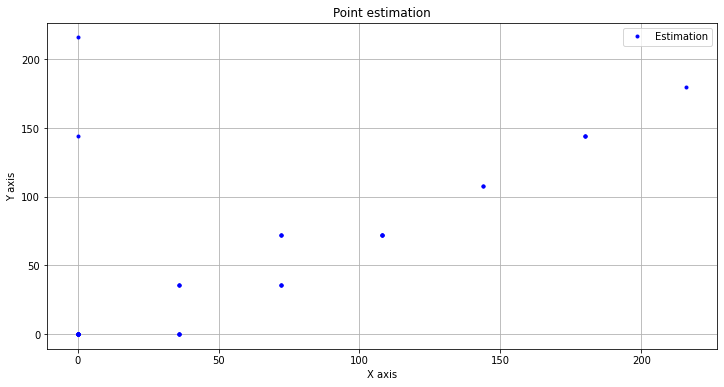

In [117]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot()
#ax.plot(I_pts[:,0],I_pts[:,1], color = 'r',ls = "None", marker = ".", label = 'Original')
ax.set_title("Point estimation")
ax.set_xlabel("X axis")
ax.set_ylabel("Y axis")
ax.grid()
ax.plot(predictions[:,0],predictions[:,1], color = 'b',ls = "None", marker = ".", label = 'Estimation')
ax.legend()
plt.show()

In [120]:
import random

## Finding Projection Matrix using DLT
def projection_matrix_estimation(img_pts, world_pts):
    n = world_pts.shape[0]
    A =  np.zeros((2*n,12))
    for i in range(n):
        A[i*2,0:4] = -1 * world_pts[i,:]
        A[i*2,8:12] = img_pts[i,0]*world_pts[i,:]
        A[i*2+1,4:8] = -1 * world_pts[i,:]
        A[i*2+1,8:12] = img_pts[i,1]*world_pts[i,:]
    
    U, D, V = np.linalg.svd(A)
    P = V[11,:]
    P = (np.reshape(P,(3,4)))
    ### P is the projection matrix
    P = P/P[2,3]
    return P


### QR Decomposition
def DLT_algorithm(P):
    temp = np.linalg.inv(P[0:3,0:3])
    R,K = np.linalg.qr(temp)
    R = np.linalg.inv(R)
    K = np.linalg.inv(K)
    K = K/K[2,2]
    T = -1*np.matmul(temp,P[:,3])
    return R,K,T


### Reprojection Error for RANSAC
def reprojection_error(P,I_pts,W_pts):
    param = 10
    inliers = 0
    n = I_pts.shape[0]
    for i in range(n):
        projected_points = np.matmul(P,np.transpose(W_pts[i,:]))
        projected_points = projected_points/projected_points[2]
        error = np.abs(projected_points[0] - I_pts[i,0]) + np.abs(projected_points[1] - I_pts[i,1])
        if (error < param):
            inliers = inliers + 1
    return inliers

### RANSAC Algorithm
def RANSAC(img_points,world_points):
    N = 2000
    n = img_points.shape[0]
    I_pts = np.zeros((6,3))
    W_pts = np.zeros((6,4))
    I_rep = np.zeros((n-6,3))
    W_rep = np.zeros((n-6,4))
    current_best_inliers = 0
    best_projection_matrix = []
    for i in range(N):
        p = 0
        q = 0
        l  = random.sample(range(n),6)
        for j in range(n):
            if j in l:
                I_pts[q,:] = img_points[j,:]
                W_pts[q,:] = world_points[j,:]
                q = q + 1
            else:
                I_rep[p,:] = img_points[j,:]
                W_rep[p,:] = world_points[j,:]
                p = p + 1
        if (((np.sum(W_pts,axis=1))[1] == 0) or ((np.sum(W_pts,axis=1))[2] == 0)):
            continue
        P = projection_matrix_estimation(I_pts, W_pts)
        inl = reprojection_error(P,I_rep,W_rep)
        if (inl > current_best_inliers):
            best_projection_matrix =  P.copy()
            current_best_inliers = inl
            # print(current_best_inliers)
    return best_projection_matrix

In [121]:
### Estimating P Matrix with RANSAC Algorithm
P_best = RANSAC(image_pts,world_pts)
print('Projection Matrix after RANSAC is:')
print(P_best)
R_best,K_best,T_best = DLT_algorithm(P_best)
print('Camera Matirx is :')
print(K_best)
print('Rotation Matrix is :')
print(R_best)
print('Projection Center is:')
print(T_best)


Projection Matrix after RANSAC is:
[[-2.12173065e+01 -7.20006307e-01 -9.50695559e+00  4.82365869e+03]
 [-1.07534267e+00 -2.23751642e+01  4.54291262e+00  2.15914187e+03]
 [ 3.82335380e-04 -2.70299051e-04 -1.53764467e-03  1.00000000e+00]]
Camera Matirx is :
[[-1.42372757e+04  2.08515562e+01  2.59360106e+03]
 [-0.00000000e+00 -1.42106646e+04 -5.21963493e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Rotation Matrix is :
[[-0.97054093 -0.00227216 -0.2409256 ]
 [-0.03834135 -0.98575645  0.1637503 ]
 [-0.23786604  0.16816378  0.95662986]]
Projection Center is:
[-48.74044248 220.5494983  599.45610455]


In [122]:

pts = np.zeros((worldm,3))
for j in range(worldm):
    pts[j,:]  = np.dot(P_best,world_pts[j])
    pts[j,:] /= pts[j,2]


In [126]:
print(pts[:5])
print(image_pts[:5])

[[1.77665280e+02 2.97102078e+02 1.00000000e+00]
 [9.07890637e+02 3.37890481e+02 1.00000000e+00]
 [1.65752682e+03 3.79763120e+02 1.00000000e+00]
 [2.42735823e+03 4.22763809e+02 1.00000000e+00]
 [3.21821209e+03 4.66938755e+02 1.00000000e+00]]
[[ 140  285    1]
 [ 908  338    1]
 [1655  391    1]
 [2450  431    1]
 [3223  465    1]]


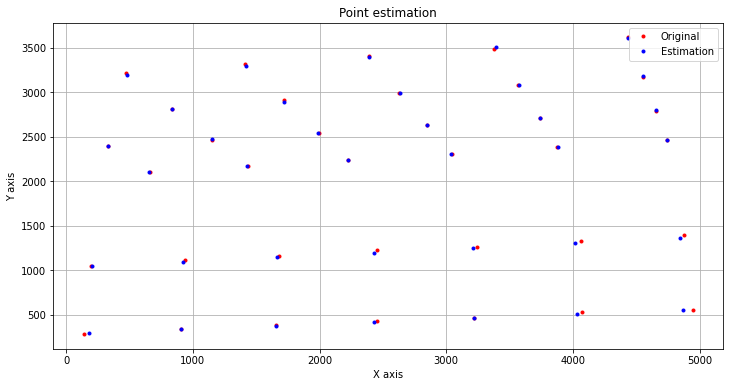

In [128]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot()
ax.plot(image_pts[:,0],image_pts[:,1], color = 'r',ls = "None", marker = ".", label = 'Original')
ax.set_title("Point estimation")
ax.set_xlabel("X axis")
ax.set_ylabel("Y axis")
ax.grid()
ax.plot(pts[:,0],pts[:,1], color = 'b',ls = "None", marker = ".", label = 'Estimation')
ax.legend()
plt.show()

In [130]:
print(xEst.shape)
# Mean distance:
err = np.sqrt(np.mean(np.sum(np.square(I_pts-pts[:,:2]), 1)))
print("Geometric Error after normalization : ",err) 

(36, 3)
Geometric Error after normalization :  24.24807731769186
